# Sentiment Analysis with an RNN

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Tutorials/blob/master/Keras-Tutorials/6.%20Sentiment%20Analysis/Sentiment%20Analysis.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Tutorials/blob/master/Keras-Tutorials/6.%20Sentiment%20Analysis/Sentiment%20Analysis.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

<img src="http://www.polyvista.com/blog/wp-content/uploads/2015/06/sentiment-customer-exp-large.png">
<p style="font-size:10px;">http://www.polyvista.com/blog/wp-content/uploads/2015/06/sentiment-customer-exp-large.png</p>

## What is Sentiment Analysis?

Sentiment Analysis also know as opinion mining refers to the identification, extraction and study of sentiment states by using natural language processing, text analysis, computational linguistics and biometrics.

## Sentiment Analysis with an Recurrent Neural Network

We will use a RNN for sentiment analysis because we care for the sequence in the data.

### Imports

In [27]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential, load_model
from tensorflow.compat.v1.keras.layers import CuDNNGRU, Embedding, Dropout,Dense, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop, Adamax , Adam

from attention.layers import AttentionLayer

# import keras
# from keras.models import Sequential, load_model
# from keras.layers import Dense, Embedding, Dropout
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.python.client import device_lib

In [28]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/erolerten/anaconda3/envs/venv-tensorflow/lib/python3.7/site-packages/tensorflow_core/python/client/session.py:1752: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [29]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #This is for multiple print statements per cell

In [30]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n\n',value) # MUST RETURN True IF IT CAN!!

***If TF can access GPU: ***

 True


In [31]:
value = tf.config.list_physical_devices('GPU')
print(value)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [32]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12480975440312667733
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7372522446858512842
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 12170191564426364435
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1259942707
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16450249716968511498
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


In [33]:
tf.debugging.set_log_device_placement(True)

In [34]:
 tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


<module 'tensorflow' from '/home/erolerten/anaconda3/envs/venv-tensorflow/lib/python3.7/site-packages/tensorflow/__init__.py'>

Num GPUs Available:  1


# Place tensors on the CPU
# with tf.device('/GPU:0'):
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

c = tf.matmul(a, b)
print(c)


### Loading in Dataset

In [35]:
data1 = pd.read_csv('Tweets.csv')
data2 = pd.read_csv('stanford-tweets.csv',sep=',')
# data1 = data1.sample(frac=1).reset_index(drop=True)
# data2 = data2.sample(frac=1).reset_index(drop=True)
print(data1.shape)
print(data2.shape)

data1.head()
data2.head()

(14640, 15)
(1600000, 2)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


,sentiment,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


Removing all columns except the airline_sentiment and text column.

In [36]:
data1 = data1[['airline_sentiment', 'text']]
new_columns = ['sentiment','text']
data1.columns = new_columns
data1.head()

,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [37]:
df = data1.append(data2, ignore_index = True) 
print(df.shape)
df

(1614640, 2)


,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
1614635,positive,Just woke up. Having no school is the best fee...
1614636,positive,TheWDB.com - Very cool to hear old Walt interv...
1614637,positive,Are you ready for your MoJo Makeover? Ask me f...
1614638,positive,Happy 38th Birthday to my boo of alll time!!! ...


### Data exploration

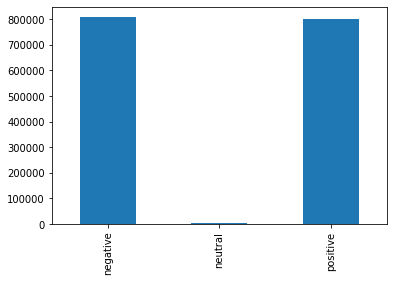

In [38]:
df['sentiment'].value_counts().sort_index().plot.bar()

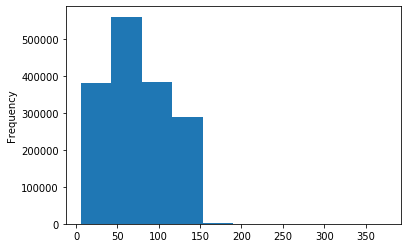

In [39]:
df['text'].str.len().plot.hist()

### Preprocessing

In [40]:
# How much of Dataset to be used
frac = 0.5

In [41]:
# data['text'] = data['text'].str.replace('@VirginAmerica', '')
# data.head()
df = df.sample(frac=frac).reset_index(drop=True)
df

,sentiment,text
0,negative,"@Nicolawills13 bubba call me when you get in,..."
1,negative,"@peterlyle oh plus two tripods and reflectors,..."
2,negative,hmm this picture works. why wont the one i act...
3,positive,http://twitpic.com/6jckg - lunch: pan fried no...
4,negative,"@8bitjoystick Thanks for the heads up dude, I'..."
...,...,...
807315,negative,Having mixed emotions Great time with Elliott...
807316,negative,@ubuntugeeks I'm fine... boring at work
807317,positive,http://twitpic.com/6azzd - tuna belly / toro &...
807318,positive,@jimmyfallon watching and loving it already e...


In [42]:
df['text'].apply(lambda x: x.lower()) #transform text to lowercase
df['text'] = df['text'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))
df['text'].head()

0         @nicolawills13  bubba call me when you get in,...
1         @peterlyle oh plus two tripods and reflectors,...
2         hmm this picture works. why wont the one i act...
3         http://twitpic.com/6jckg - lunch: pan fried no...
4         @8bitjoystick thanks for the heads up dude, i'...
                                ...                        
807315    having mixed emotions  great time with elliott...
807316             @ubuntugeeks i'm fine... boring at work 
807317    http://twitpic.com/6azzd - tuna belly / toro &...
807318    @jimmyfallon watching and loving it already  e...
807319    new wallpapers on site - tommy haas who won ha...
Name: text, Length: 807320, dtype: object

0    Nicolawills13  bubba call me when you get in h...
1    peterlyle oh plus two tripods and reflectors a...
2    hmm this picture works why wont the one i actu...
3    httptwitpiccom6jckg  lunch pan fried noodles a...
4    8bitjoystick Thanks for the heads up dude Ill ...
Name: text, dtype: object

In [43]:
df['sentiment']

0         negative
1         negative
2         negative
3         positive
4         negative
            ...   
807315    negative
807316    negative
807317    positive
807318    positive
807319    positive
Name: sentiment, Length: 807320, dtype: object

In [44]:
df = df[df['sentiment'] != 'neutral']

In [45]:
df

,sentiment,text
0,negative,Nicolawills13 bubba call me when you get in h...
1,negative,peterlyle oh plus two tripods and reflectors a...
2,negative,hmm this picture works why wont the one i actu...
3,positive,httptwitpiccom6jckg lunch pan fried noodles a...
4,negative,8bitjoystick Thanks for the heads up dude Ill ...
...,...,...
807315,negative,Having mixed emotions Great time with Elliott...
807316,negative,ubuntugeeks Im fine boring at work
807317,positive,httptwitpiccom6azzd tuna belly toro amp scal...
807318,positive,jimmyfallon watching and loving it already ev...


In [46]:
vocabulary_size = 10000

In [47]:
tokenizer = Tokenizer(num_words=vocabulary_size, split=" ", oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'].values)

X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           1, 8271,  315,   16,   79,    8,   33,   12,   18,   38, 2680,
           7,   38, 6210,   90,    3, 1225,    1,  740],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1,   82,  812,  272,
           1,    7,    1,    5, 8393,  812,  898, 2405,  993,  115,  161,
         273,    1,    7,    1,   68,    2, 5338,  129],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,  786,   28,  526,  626,  112,
         184,    4,   57,    2,  274, 3990,   47,  130],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  

### Creating model

In [48]:
model = Sequential()
model.add(Embedding(vocabulary_size, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(Bidirectional(CuDNNGRU(256, return_sequences=True)))
# model.add(Dropout(0.3))
# model.add(Bidirectional(CuDNNGRU(256, return_sequences=True)))
model.add(AttentionLayer(name='attention'))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [49]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 256)           2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 256)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 41, 512)           789504    
_________________________________________________________________
attention (AttentionLayer)   (None, 512)               263168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 3,615,746
Trainable params: 3,614,722
Non-trainable params: 1,024
________________________________________

In [50]:
y = pd.get_dummies(df['sentiment']).values
[print(df['sentiment'][i], y[i]) for i in range(0,5)]

negative [1 0]
negative [1 0]
negative [1 0]
positive [0 1]
negative [1 0]


[None, None, None, None, None]

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Training model

In [52]:
batch_size = 32
epochs = 7
import time
from datetime import datetime
datetime = str(datetime.now())
csv_logger = tf.keras.callbacks.CSVLogger('training'+datetime+'.log')
start = time.time()
print("started at:")
print(start)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[csv_logger])
end = time.time()
elapsed = end - start
print(elapsed/60," minutes")


started at:
1585745134.4123294
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train on 644611 samples
Epoch 1/7
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device 

### Plotting Training History

In [53]:
# print(history)

Text(0.5, 1.0, 'Model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

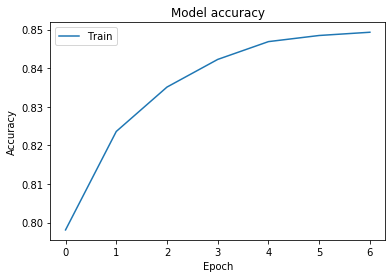

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

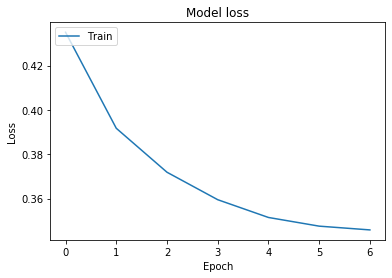

In [54]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Testing model

In [55]:
predictions = model.predict(X_test)

[print(df['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_676254 in device /job:localhost/replica:0/task

[None, None, None, None, None]

In [56]:
accurate_prediction_count, inaccurate_prediction_count = 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==np.argmax(y_test[i]):
        accurate_prediction_count += 1
    else:
        inaccurate_prediction_count += 1

total_predictions = accurate_prediction_count + inaccurate_prediction_count
print('Number of predictions: ', total_predictions)
print('Number of accurate predictions: ', accurate_prediction_count)
print('Number of false predictions: ', inaccurate_prediction_count)    
print('Accuracy: ', accurate_prediction_count/total_predictions)

Number of predictions:  161153
Number of accurate predictions:  132199
Number of false predictions:  28954
Accuracy:  0.8203322308613553


In [57]:
name = 'Sentiment_Analysis-binary-classification-BRNN-CuDNNGRU-Batchnormalization-AttentionLayer-9_epoch-20_frac-23k_vocab'

In [58]:
model.save(name+'.h5')

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0


In [59]:
# pos_count, neu_count, neg_count = 0, 0, 0
# real_pos, real_neu, real_neg = 0, 0, 0
# for i, prediction in enumerate(predictions):
#     if np.argmax(prediction)==2:
#         pos_count += 1
#     elif np.argmax(prediction)==1:
#         neu_count += 1
#     else:
#         neg_count += 1
    
#     if np.argmax(y_test[i])==2:
#         real_pos += 1
#     elif np.argmax(y_test[i])==1:    
#         real_neu += 1
#     else:
#         real_neg +=1

# print('Positive predictions:', pos_count)
# print('Neutral predictions:', neu_count)
# print('Negative predictions:', neg_count)
# print('Real positive:', real_pos)
# print('Real neutral:', real_neu)
# print('Real negative:', real_neg)

In [60]:
# !jupyter nbconvert Sentiment_Analysis-binary-classification-BRNN-CuDNNGRU-Batchnormalization-AttentionLayer.ipynb --to pdf 

## Improvements we could implement
<ul>
    <li>Weight classes (because data is skew)</li>
    <li>Train more epochs</li>
    <li>Use bigger network</li>
    <li>Try other word number</li>
</ul>

## Resources

<ul>
    <li><a href="https://programmingwithgilbert.firebaseapp.com/videos/machine-learning-explained/recurrent-neural-networks-lstm-explained">Recurrent Neural Networks Explained (my own post and video)</a></li>
    <li><a href="https://en.wikipedia.org/wiki/Sentiment_analysis">Sentiment Analysis (Wikipedia)</a></li>
    <li><a href="https://www.quora.com/What-is-the-best-way-to-do-sentiment-analysis-with-Python-I%E2%80%99m-looking-for-a-sentiment-analysis-API-that-I-can-add-an-emoticon-dictionary-to-I-have-no-idea-how-to-use-NLTK-Can-anyone-help-me-with-that">What is the best way to do sentiment analysis with Python? (Quora)</a></li>
    <li><a href="https://www.youtube.com/watch?v=si8zZHkufRY">How to Do Sentiment Analysis (Siraj Raval)</a></li>
</ul>